In [12]:
#!/usr/bin/env python

# 4km-comgrid_draft_structure_examle.ipynb

In [13]:
'''This program reads in W and Z data for a signle simulated case 
that are conservatively regridded to a common 4 km grid and
plots zoomed in maps of deep convective activity to showcase the 
how convective structures depend on horizontal grid spacing'''

'This program reads in W and Z data for a signle simulated case \nthat are conservatively regridded to a common 4 km grid and\nplots zoomed in maps of deep convective activity to showcase the \nhow convective structures depend on horizontal grid spacing'

In [14]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
# import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys 
import matplotlib.gridspec as gridspec
import seaborn
# from mpl_toolkits.basemap import Basemap, cm
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.crs as ccrs

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import wrf


In [15]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from metpy.plots import ctables
# READ AND PARSE HERE
dbzmap = ctables.registry.get_colortable('NWSReflectivity')
# dbzmap = ctables.registry.get_colortable('NWSStormClearReflectivity')


In [16]:
def disctance(lat1, lon1, lat2, lon2):
    from math import sin, cos, sqrt, atan2, radians

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    # Approximate radius of earth in km
    R = 6373.0

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    
    return distance

In [17]:
from draft_functions import core_2d_properties, core_3d_properties, \
                            watersheding, interpolate_obs, remove_noise

In [18]:
# DX = ['500M','250M','125M']
# DT = [2,1,0.5]
# dx_m = [500,250,125] 

DX_all = ['4KM','2KM','1KM','500M','250M','125M'] #,'obs']
colors = ['#a6cee3','#33a02c','#ff7f00','#fb9a99','#e31a1c','k']
color_cortype = ['#e41a1c', '#377eb8', '#33a02c']
dx_km = [4,2,1,0.5,0.25,0.125]
DT_all = [16,8,4,2,1,0.5]
dx_m_all = [4000,2000,1000,500,250,125]

SIM_All = ['mao_20140401_15:00:00_', #125 | 0
        'mao_20140917_17:00:00_',
        'mao_20141004_13:00:00_',
        'mao_20141018_14:00:00_',
        'mao_20141117_18:00:00_',
        'mao_20141210_14:00:00_',
        'mao_20150328_15:00:00_',
        'mao_20150412_12:00:00_',
        'mao_20150621_14:00:00_',
        'mao_20151106_12:00:00_', #125 | 9
        'sgp_20120531_04:00:00_',
        'sgp_20120615_07:00:00_', #125 | 11
        'sgp_20130509_07:00:00_',
        'sgp_20130605_09:00:00_',
        'sgp_20130617_07:00:00_',
        'sgp_20140602_04:00:00_',
        'sgp_20140605_12:00:00_',
        'sgp_20140612_06:00:00_', #125 | 17
        'sgp_20140628_16:00:00_',
        'sgp_20140710_10:00:00_']
si = 9 #17 #10
SIM = SIM_All[si]
Site = SIM[:3].upper()

if si == 0:
    t_foc = 50
    zlev = 15
if si == 9:
    t_foc = 50
    zlev = 15
if si == 11:
    t_foc = 50
    zlev = 15
if si == 17:
    t_foc = 50
    zlev = 15
    
wrfout_dir = '/glade/campaign/mmm/c3we/prein/Projects/2019_ASR-MCS/data/Coarsened_Data/4km_more-vars/'

VARS = ['WW','QS','QR','QC','QG','QV','TK','P'] # virtual profiler variables

In [19]:
if Site == 'SGP':
    proj_File = '/glade/campaign/mmm/c3we/mingge/WRFV4.1.5_intel_dmpar/Thomson_YSU/sgp_20120531_04:00:00_L4/wrfout_d01_2012-05-30_04:00:00'
    extension = [-111, -88, 28, 48]
    ARMlon = -97.4882
    ARMlat = 36.6077
if Site == 'MAO':
    proj_File = '/glade/campaign/mmm/c3we/mingge/WRFV4.1.5_intel_dmpar/Thomson_YSU/mao_20150303_20:00:00_L4/wrfout_d01_2015-03-02_20:00:00'
    extension = [-69, -49, -13.5,6]
    ARMlon = -60.025
    ARMlat = -3.113

### Read in W and Z at time t_foc

In [20]:
Data_3D = {}
for dx in tqdm(range(len(DX_all))):
    print(DX_all[dx])

    if np.isin(DX_all[dx], ('500M','250M','125M')) == True:
        subkm = True
    else:
        subkm = False

    if subkm == True:
        wrfout_files = np.sort(glob.glob(wrfout_dir+DX_all[dx]+'/'+SIM+'L/wrfout_d02*'))
    else:
        if DX_all[dx] != '12KM':
            wrfout_files = np.sort(glob.glob(wrfout_dir+DX_all[dx]+'/'+SIM+'L/wrfout_d01*'))
        else:
            wrfout_files = np.sort(glob.glob(wrfout_dir+DX_all[dx]+'/'+SIM+'L/wrfout_d01*'))
        # only focus the analysis on 18 - 30 hours 
        wrfout_files = wrfout_files[18*6+1:18*6+1+12*6]

    # read in key variables at t_foc
    ncfile = Dataset(wrfout_files[t_foc])
    lat = np.squeeze(ncfile.variables["XLAT"])
    lon = np.squeeze(ncfile.variables['XLONG'])
    dbz = np.squeeze(ncfile.variables["REFL_10CM"][:,:,:,:])
    ww = np.squeeze(ncfile.variables["W"][:,:,:,:])
    zz = np.squeeze(ncfile.variables["PHB"][:,:,:,:]) + np.squeeze(ncfile.variables["PH"][:,:,:,:])
    HGT = getvar(ncfile, "HGT")
    ncfile.close()
    
    data_act = {}
    data_act['lon'] = lon
    data_act['lat'] = lat
    data_act['ww'] = ww
    data_act['zz'] = zz
    data_act['dbz'] = dbz
    data_act['HGT'] = HGT
    
    Data_3D[DX_all[dx]] = data_act

  0%|          | 0/6 [00:00<?, ?it/s]

4KM


 17%|█▋        | 1/6 [00:01<00:05,  1.09s/it]

2KM


 33%|███▎      | 2/6 [00:02<00:04,  1.12s/it]

1KM


 50%|█████     | 3/6 [00:03<00:03,  1.21s/it]

500M


 67%|██████▋   | 4/6 [00:04<00:02,  1.17s/it]

250M


 83%|████████▎ | 5/6 [00:05<00:01,  1.17s/it]

125M


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


### Plot the data

100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


        Plot map to: mao_20151106_12:00:00__draft-examples_zoomed.pdf


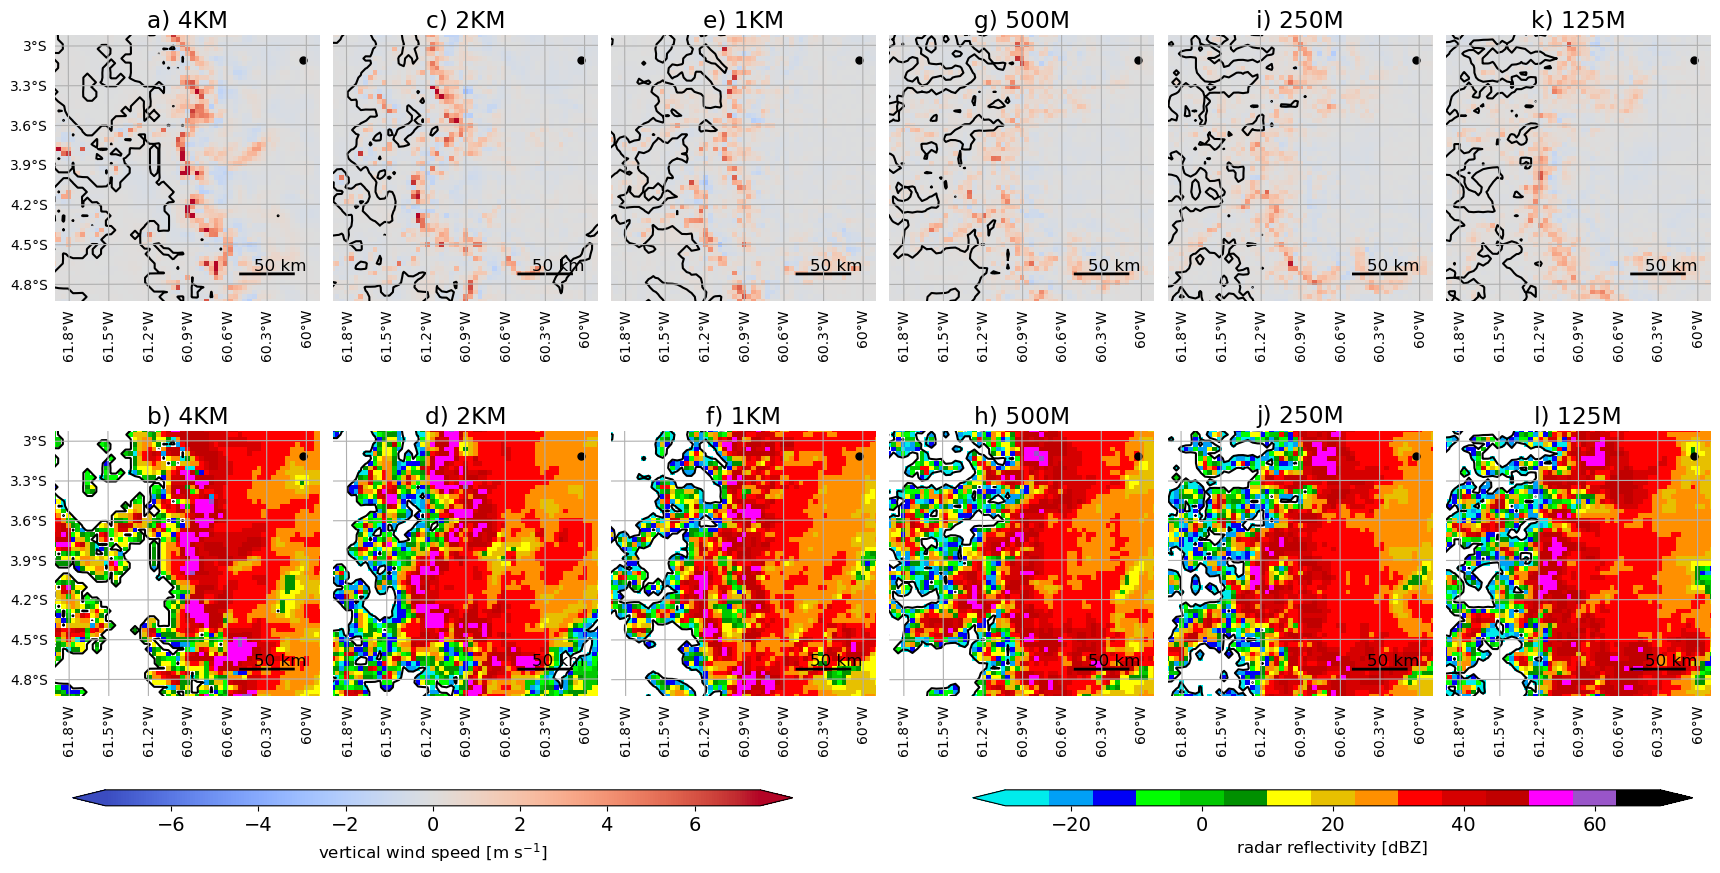

100%|██████████| 6/6 [00:00<00:00, 16.03it/s]


        Plot map to: mao_20151106_12:00:00__draft-examples_unzoomed.pdf


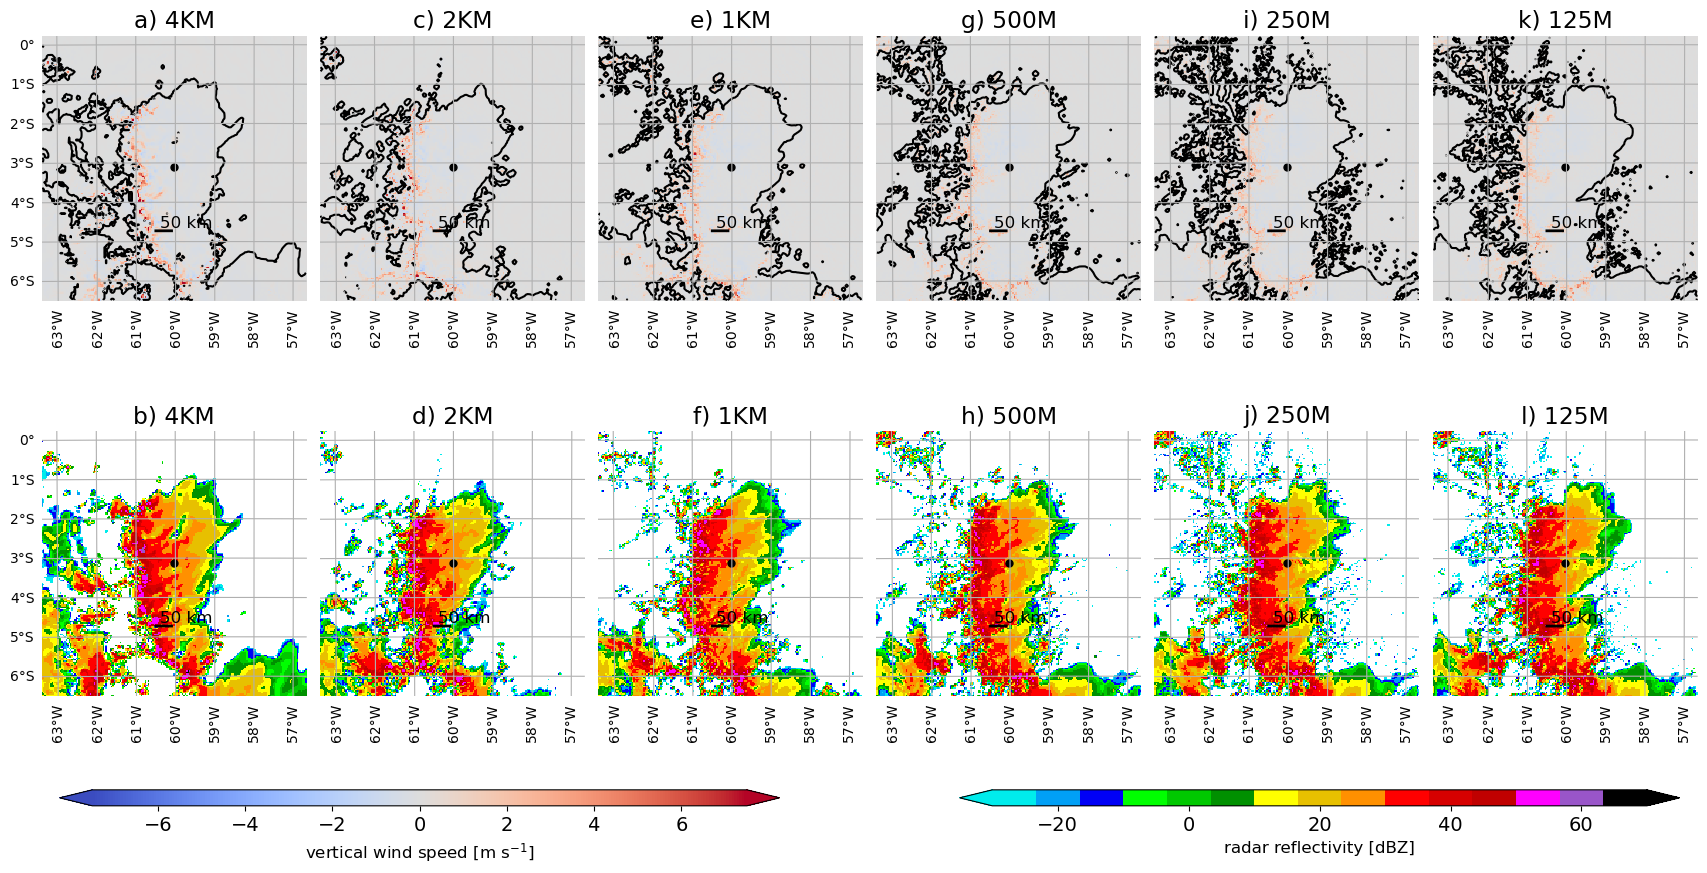

In [21]:
zoom = ['zoomed', 'unzoomed']

for zo in range(2): # plot a zoomed in and a zoomed out version of the storm

    fig = plt.figure(figsize=(18,8))
    gs1 = gridspec.GridSpec(2,len(DX_all))
    gs1.update(left=0.04, right=0.96,
       bottom=0.07, top=0.93,
       wspace=0.05, hspace=0.35)
    plt.rcParams.update({'font.size': 14})
    abc_list = list(string.ascii_lowercase)
    ylab = True
    count = 0
    mar = 1
    
    # ========================================
    # plot horizontal cross-sections
    for dx in tqdm(range(6)): #tqdm(range(len(DX_all))):
        
        if dx == 0:
            # find strongest updraft in 200 km radius arround ARM site
            dist = disctance(ARMlat, ARMlon,
                             Data_3D[DX_all[dx]]['lat'],Data_3D[DX_all[dx]]['lon'])
            dist = dist < 200
            ww_search = np.copy(Data_3D[DX_all[dx]]['ww'][zlev,:,:])
            ww_search[dist == 0] = 0
            max_ud = np.where(ww_search == np.max(ww_search[dist]))
    
            foc_lon = Data_3D[DX_all[dx]]['lon'][max_ud[0][0], max_ud[1][0]]
            foc_lat = Data_3D[DX_all[dx]]['lat'][max_ud[0][0], max_ud[1][0]]
        
        HGT = Data_3D[DX_all[dx]]['HGT']
        proj = get_cartopy(HGT)
        
        # =====================================
        # Horizontal cross section through drafts
        ax = plt.subplot(gs1[0,dx], projection=proj)
        if zo == 0:
            ax.set_extent([foc_lon-mar,foc_lon+mar,foc_lat-mar,foc_lat+mar], ccrs.Geodetic())
        cs = plt.pcolormesh(Data_3D[DX_all[dx]]['lon'],
                      Data_3D[DX_all[dx]]['lat'],
                      Data_3D[DX_all[dx]]['ww'][zlev,:,:],
                      vmin=-7.5, vmax=7.5, cmap='coolwarm', 
                      transform=ccrs.PlateCarree())
        plt.contour(Data_3D[DX_all[dx]]['lon'],
                      Data_3D[DX_all[dx]]['lat'],
                      Data_3D[DX_all[dx]]['dbz'][zlev,:,:],
                      levels = [-30], colors='k', linestyles = '-', 
                      transform=ccrs.PlateCarree())
        ax.coastlines()

        plt.plot([foc_lon+mar/2.5, foc_lon+mar/2.5+0.08*5],
                 [foc_lat-mar/1.25, foc_lat-mar/1.25],
                  c='k', lw = 2, transform=ccrs.PlateCarree())
        plt.text(foc_lon+mar/2,foc_lat-mar/1.26, '50 km',
                 va='bottom', ha = 'left', transform=ccrs.PlateCarree(), fontsize = 12)
        
        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
        gl.ylabel_style = {'size': 10}
        gl.xlabel_style = {'size': 10}
        gl.top_labels=False
        gl.right_labels=False
        if dx > 0:
            gl.left_labels=False
        
        # plot ARM location
        ax.plot(ARMlon,ARMlat,'ko', transform=ccrs.PlateCarree(), markersize=5)
        plt.title(abc_list[dx*2]+') '+DX_all[dx])
        ax.axis('off')
        
    # ====================================  
    # plot colot table
    CbarAx = plt.axes([0.05, -0.05, 0.4, 0.02])
    cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=Levels)
    cb.set_label('vertical wind speed [m s$^{-1}$]', fontsize=12)
    
    
    # ========================================
    # plot reflectivity field
    for dx in tqdm(range(6)): #tqdm(range(len(DX_all))):
        
        HGT = Data_3D[DX_all[dx]]['HGT']
        proj = get_cartopy(HGT)
        
        # =====================================
        ax = plt.subplot(gs1[1,dx], projection=proj)
        if zo == 0:
            ax.set_extent([foc_lon-mar,foc_lon+mar,foc_lat-mar,foc_lat+mar], ccrs.Geodetic())
        dbz_act = np.copy(Data_3D[DX_all[dx]]['dbz'][zlev,:,:])
        dbz_act[dbz_act <= -30] = np.nan
        cs = plt.pcolormesh(Data_3D[DX_all[dx]]['lon'],
                      Data_3D[DX_all[dx]]['lat'],
                      dbz_act,
                      vmin=-30, vmax=70, cmap=dbzmap, 
                      transform=ccrs.PlateCarree())
        if zo == 0:
            plt.contour(Data_3D[DX_all[dx]]['lon'],
                          Data_3D[DX_all[dx]]['lat'],
                          Data_3D[DX_all[dx]]['dbz'][zlev,:,:],
                          levels = [-30], colors='k', linestyles = '-', 
                          transform=ccrs.PlateCarree())
        ax.coastlines()
        
        plt.plot([foc_lon+mar/2.5, foc_lon+mar/2.5+0.08*5],
                 [foc_lat-mar/1.25, foc_lat-mar/1.25],
                  c='k', lw = 2, transform=ccrs.PlateCarree())
        plt.text(foc_lon+mar/2,foc_lat-mar/1.26, '50 km',
                 va='bottom', ha = 'left', transform=ccrs.PlateCarree(), fontsize = 12)
        
        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
        gl.ylabel_style = {'size': 10}
        gl.xlabel_style = {'size': 10}
        gl.top_labels=False
        gl.right_labels=False
        if dx > 0:
            gl.left_labels=False
        
        # plot ARM location
        ax.plot(ARMlon,ARMlat,'ko', transform=ccrs.PlateCarree(), markersize=5)
        plt.title(abc_list[dx*2+1]+') '+DX_all[dx])
        ax.axis('off')
        
    # ====================================  
    # plot colot table
    CbarAx = plt.axes([0.55, -0.05, 0.4, 0.02])
    cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=Levels)
    cb.set_label('radar reflectivity [dBZ]', fontsize=12)
    
    sPlotFile=''
    sPlotName= SIM+'_draft-examples_'+zoom[zo]+'.pdf'
    print( '        Plot map to: '+sPlotFile+sPlotName)
    fig.savefig(sPlotFile+sPlotName, bbox_inches='tight', dpi=700)
    
    plt.show()